## **Lưu ý 1: Sau mỗi cell `Question` là 1 cell `Answer`**

## **Lưu ý 2:**

1. Các lần train được tiến hành trên nhiều `Notebook` khác nhau

2. Trong file này, ta sử dụng 4 model, nhưng `KNN()` là model chính, được train trên dữ liệu gốc (bao gồm dữ liệu chưa qua xử lý PCA, và dữ liệu đã qua xử lý PCA để so sánh hiệu suất | Kết quả : **`88.5%`** với metric `accuracy` được tính thông qua hàm `accuracy_score()`

3. Còn các kết quả của model khác như `GaussNB()`, `RandomForestClassifier()` là được train trên tập dữ liệu nhỏ hơn (được train trên các notebook khác) (vẫn là data này nhưng cắt bớt mỗi class khoảng `N` images để giảm bớt thời gian train )

4. Bổ sung: `GaussNB()` được train trên tập dữ liệu gốc giống như `KNN()`

5. Bổ sung: `MLP()` cũng được train trên tập dữ liệu gốc

## **Accuracy cao nhất đạt được: 88.5%**

* Data: 35.000 (x2) images về biểu cảm khuôn mặt
* Model : `KNN()`
* Hyperparameters :
```
    (n_neighbors=5,
     weights='distance',
     algorithm = 'ball_tree')
```

## 1. Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

### Chuẩn bị dữ liệu

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Đường dẫn tới file CSV trong Google Drive
file_path = '/content/drive/My Drive/Data/icml_face_data.csv'
df = pd.read_csv(file_path)

In [ ]:
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
df.shape

(35887, 2)

In [ ]:
""" Kiểm tra số lượng row của từng class """

emotion_counts = df['emotion'].value_counts()
print(emotion_counts)

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64


### Đối với model train nhanh như KNN, ta x2 dữ liệu lên

In [ ]:
import pandas as pd

df_2 = pd.DataFrame(columns=df.columns)

for emotion in emotion_counts.index:
    # Lấy tất cả các row tương ứng với emotion hiện tại
    emotion_df = df[df['emotion'] == emotion]

    # Duplicate các row
    duplicated_emotion_df = pd.concat([emotion_df] * 2, ignore_index=True)

    # Append vào dataframe mới
    df_2 = pd.concat([df_2, duplicated_emotion_df], ignore_index=True)

""" ------------------------------------------------------------------------ """

# Kiểm tra số lượng row của từng class trong df_2
emotion_counts_2 = df_2['emotion'].value_counts()
print(emotion_counts_2)

emotion
3    17978
6    12396
4    12154
2    10242
0     9906
5     8004
1     1094
Name: count, dtype: int64


In [ ]:
df_2.shape

(71774, 2)

### Shuffle dữ liệu để đảm bảo model không bias một cách bất thường

In [ ]:
df2_shuffled = df_2.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
df2_shuffled.shape

(71774, 2)

### Trục quan hóa images

In [ ]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [ ]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [ ]:
## parsing data here
images, labels = parse_data(df2_shuffled)

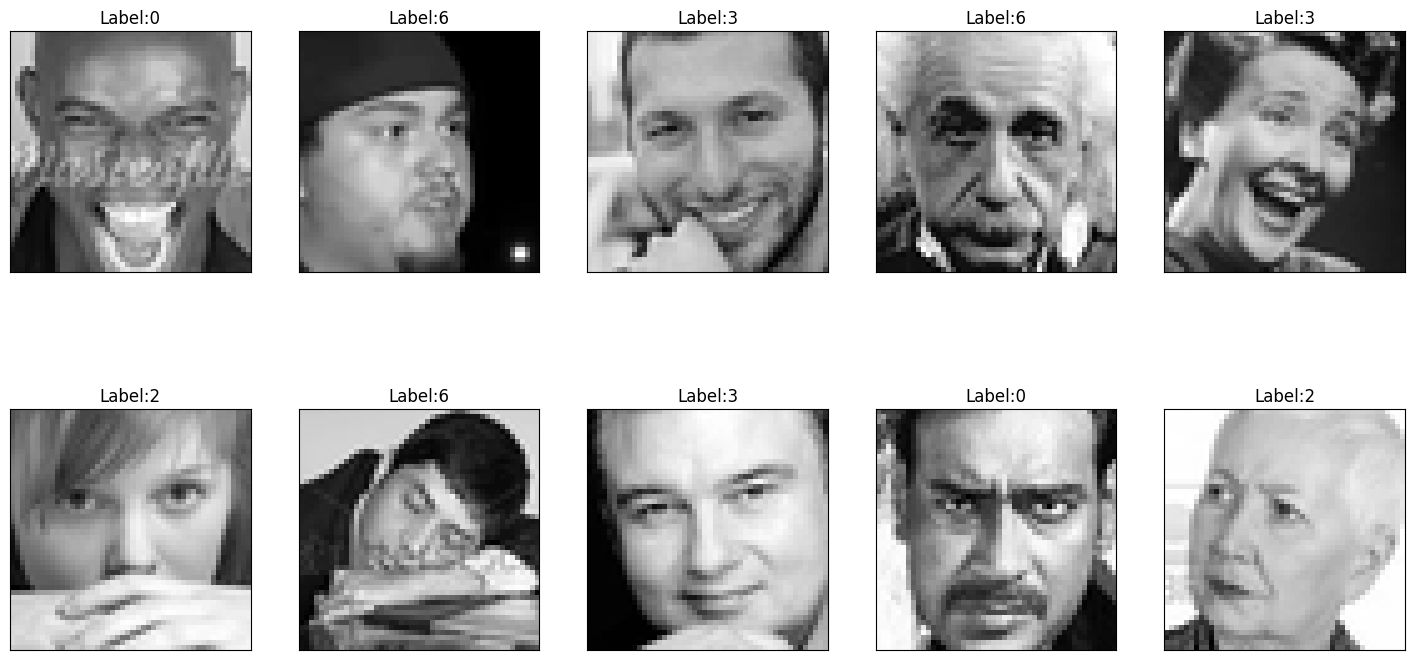

In [ ]:
## showing images here
show_img(images, labels)

## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

### **Question 1: Can you visualize the data projected onto two principal components? (2 points)**

***Answer 1: Sử dụng PCA với (n_components = 2) và plot lên biểu đồ với Matplotlib***

In [ ]:
from sklearn.decomposition import PCA

# Dùng PCA
images_reshaped = images.reshape(images.shape[0], -1)
pca = PCA(n_components=2)
pca.fit(images_reshaped)

PCA(n_components=2)

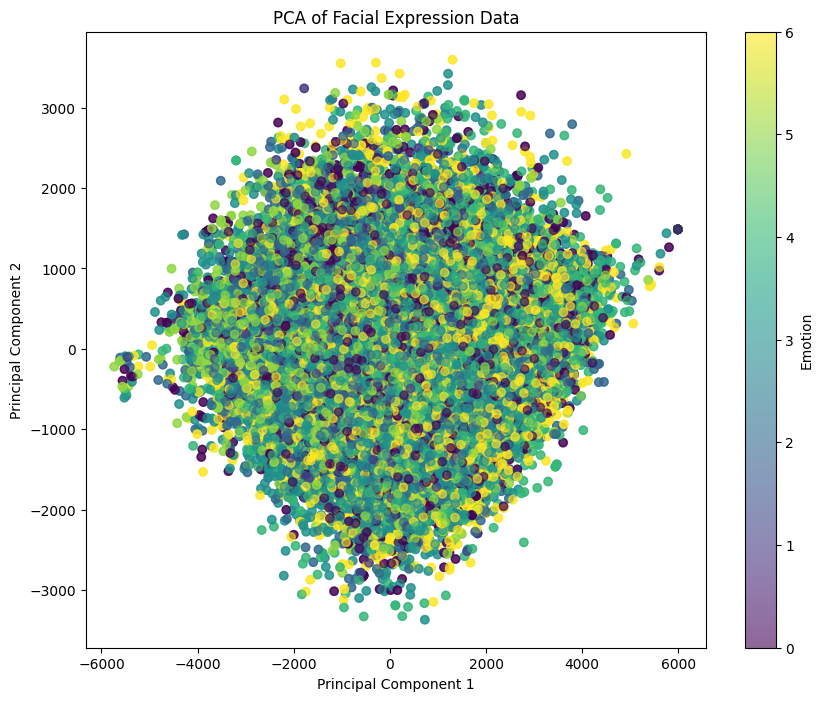

In [ ]:
import matplotlib.pyplot as plt

""" ------------------------------------------------------------------------"""
images_pca = pca.transform(images_reshaped)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(images_pca[:, 0], images_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, ticks=range(7), label='Emotion')
plt.title('PCA of Facial Expression Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
"""
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
# pca.fit(images) ## modify images' array to the appropriate shape
"""

In [ ]:
"""
## transform for visualizing here
# images_pca=pca.transform(images) ## modify images' array to the appropriate shape
# images_pca.shape
"""

### **Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_``` ? Explain your selection process. (2 points)**

***Answer 2:***

--------

*Trong các tấm ảnh, ta thấy rằng khuôn mặt chiếm gần hết các pixel trong tấm ảnh, do đó ta giữ lại một lượng lớn thành phần chính*

*Tuy nhiên, nếu muốn xác định được là cần giữ lại bao nhiêu % lượng thông tin để tối ưu, ta cần thí nghiệm. Ví dụ, ta thí nghiệm với 3 ngưỡng là [87, 90, 93] phần trăm. Tất nhiên với mỗi ngưỡng này, ta tìm được số lượng thành phần chính tương ứng (number_of_combonents)*

*Ta có thể dùng vòng lặp, nhưng vì giai đoạn này không quá quan trọng nên ta tiết kiệm thời gian bằng cách chọn con số 93*

*Trong phần test thử pca dưới đây, ta tìm được số lượng thành phần chính tối ưu để giữ lại 93% lượng thông tin của dữ liệu là `168`, ta sẽ apply nó vào data (data mà đã được chuẩn hóa)*

### Chuẩn hóa dữ liệu với StandardScaler()

In [ ]:
from sklearn.preprocessing import StandardScaler

# normalize
scaler = StandardScaler()
images_normalized = scaler.fit_transform(images_reshaped)

In [ ]:
images_normalized

array([[ 0.99438891,  1.06227   ,  1.11665886, ..., -0.92581119,
        -0.92810831, -0.86903005],
       [-1.10370598, -1.09816461, -1.07845373, ..., -1.26127739,
        -1.33762399, -1.3514768 ],
       [ 1.29758182,  1.3955942 ,  1.51805087, ...,  0.42895619,
         0.31323607, -0.45006314],
       ...,
       [ 0.37587539,  0.34624024,  0.31387482, ..., -0.57744243,
        -0.45460582, -0.33579943],
       [ 0.04842705,  0.09933343, -0.01225619, ...,  1.37084208,
         1.4649989 ,  1.50511579],
       [-0.9703011 , -0.96236586, -0.96556223, ..., -0.77098063,
        -0.7873373 , -0.89442198]])

In [ ]:
from sklearn.preprocessing import StandardScaler

# normalize
scaler = StandardScaler()
images_normalized = scaler.fit_transform(images_reshaped)

### Dùng PCA giữ lại khoảng 93% phân phối của tấm ảnh

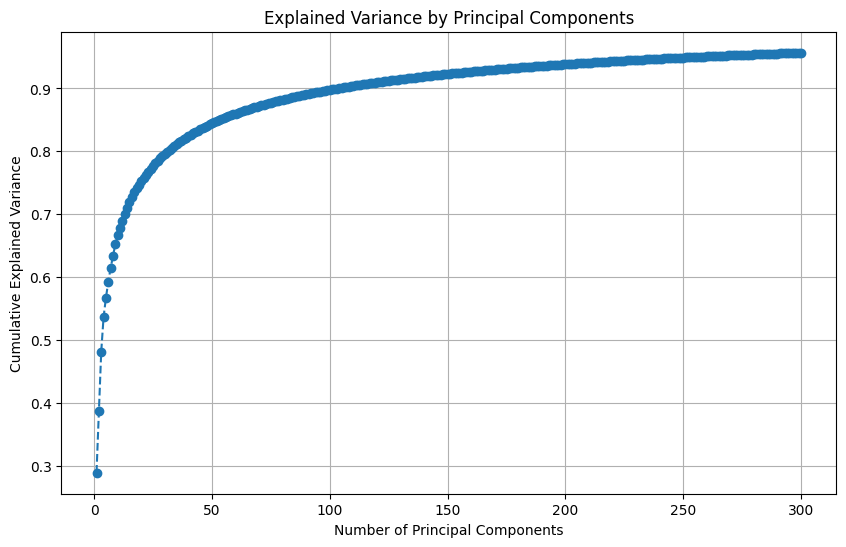

Optimal number of principal components: 171


In [ ]:
pca2 = PCA(n_components = 300)
pca2.fit(images_reshaped)

explained_variance_ratio = pca2.explained_variance_ratio_

cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid()
plt.show()

optimal_num_components = np.argmax(cumulative_explained_variance >= 0.93) + 1
print(f'Optimal number of principal components: {optimal_num_components}')

## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

### **Question 3:**
Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

### **Answer 3:**

### **Xem các bước làm bên dưới**

In [ ]:
from sklearn.decomposition import PCA

pca_171 = PCA(n_components=171)
images_pca = pca_171.fit_transform(images_normalized)

In [ ]:
print(f'Shape of data after PCA: {images_pca.shape}')

Shape of data after PCA: (71774, 171)


### **Tiến hành sử dụng 4 model cho cả 2 data gốc và data sau khi đã dùng PCA**

------

**Các model khả thi:**

1. SVM
2. Random Forest
3. KNN
4. MLP

### Split data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(images_normalized, labels, test_size=0.2, random_state=42)

print(f"Training set size: {X_train_norm.shape[0]}, Testing set size: {X_test_norm.shape[0]}")

Training set size: 57419, Testing set size: 14355


In [ ]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(images_pca,
                                                                    labels,
                                                                    test_size=0.2,
                                                                    random_state=42)

print(f"Training set size: {X_train_pca.shape[0]}, Testing set size: {X_test_pca.shape[0]}")

Training set size: 57419, Testing set size: 14355


### **Model 1.1: `KNN()` trên dữ liệu gốc**

* Mất 2 phút
* Accuracy : 48.64%

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
import numpy as np

knn_model = KNeighborsClassifier(n_neighbors=5)


num_steps = 100
progress_bar = tqdm(total=num_steps, desc="Training Progress")


knn_model.fit(X_train_norm, y_train_norm)
for i in range(num_steps):
    progress_bar.update(1)
    if (i + 1) % (num_steps // 100) == 0:
        print(f"Đã train được {i + 1} phần trăm")

progress_bar.close()


y_pred_knn = knn_model.predict(X_test_norm)
accuracy_knn = accuracy_score(y_test_norm, y_pred_knn)
print(f"Accuracy on normalized data: {accuracy_knn}")
print(classification_report(y_test_norm, y_pred_knn))
print(confusion_matrix(y_test_norm, y_pred_knn))

Training Progress: 100%|██████████| 100/100 [00:00<00:00, 195.52it/s]


Đã train được 1 phần trăm
Đã train được 2 phần trăm
Đã train được 3 phần trăm
Đã train được 4 phần trăm
Đã train được 5 phần trăm
Đã train được 6 phần trăm
Đã train được 7 phần trăm
Đã train được 8 phần trăm
Đã train được 9 phần trăm
Đã train được 10 phần trăm
Đã train được 11 phần trăm
Đã train được 12 phần trăm
Đã train được 13 phần trăm
Đã train được 14 phần trăm
Đã train được 15 phần trăm
Đã train được 16 phần trăm
Đã train được 17 phần trăm
Đã train được 18 phần trăm
Đã train được 19 phần trăm
Đã train được 20 phần trăm
Đã train được 21 phần trăm
Đã train được 22 phần trăm
Đã train được 23 phần trăm
Đã train được 24 phần trăm
Đã train được 25 phần trăm
Đã train được 26 phần trăm
Đã train được 27 phần trăm
Đã train được 28 phần trăm
Đã train được 29 phần trăm
Đã train được 30 phần trăm
Đã train được 31 phần trăm
Đã train được 32 phần trăm
Đã train được 33 phần trăm
Đã train được 34 phần trăm
Đã train được 35 phần trăm
Đã train được 36 phần trăm
Đã train được 37 phần trăm
Đã train đ

### **Model 1.2: `KNN()` trên dữ liệu sau quá trình pca**

- Mất 16 giây
- Accuracy : 49.87%

--> Giảm được rất nhiều % thời gian train, nhưng hiệu suất vẫn không bị ảnh hưởng

In [ ]:
knn_model_2 = KNeighborsClassifier(n_neighbors=5)


num_steps_2 = 100
progress_bar_2 = tqdm(total=num_steps_2, desc="Training Progress")


knn_model_2.fit(X_train_pca, y_train_pca)
for i in range(num_steps_2):
    progress_bar_2.update(1)
    if (i + 1) % (num_steps_2 // 100) == 0:
        print(f"Đã train được {i + 1} phần trăm")


progress_bar_2.close()


y_pred_knn_2 = knn_model_2.predict(X_test_pca)
accuracy_knn_2 = accuracy_score(y_test_pca, y_pred_knn_2)
print(f"Accuracy on normalized data: {accuracy_knn_2}")
print(classification_report(y_test_pca, y_pred_knn_2))
print(confusion_matrix(y_test_pca, y_pred_knn_2))

Training Progress: 100%|██████████| 100/100 [00:00<00:00, 3275.24it/s]


Đã train được 1 phần trăm
Đã train được 2 phần trăm
Đã train được 3 phần trăm
Đã train được 4 phần trăm
Đã train được 5 phần trăm
Đã train được 6 phần trăm
Đã train được 7 phần trăm
Đã train được 8 phần trăm
Đã train được 9 phần trăm
Đã train được 10 phần trăm
Đã train được 11 phần trăm
Đã train được 12 phần trăm
Đã train được 13 phần trăm
Đã train được 14 phần trăm
Đã train được 15 phần trăm
Đã train được 16 phần trăm
Đã train được 17 phần trăm
Đã train được 18 phần trăm
Đã train được 19 phần trăm
Đã train được 20 phần trăm
Đã train được 21 phần trăm
Đã train được 22 phần trăm
Đã train được 23 phần trăm
Đã train được 24 phần trăm
Đã train được 25 phần trăm
Đã train được 26 phần trăm
Đã train được 27 phần trăm
Đã train được 28 phần trăm
Đã train được 29 phần trăm
Đã train được 30 phần trăm
Đã train được 31 phần trăm
Đã train được 32 phần trăm
Đã train được 33 phần trăm
Đã train được 34 phần trăm
Đã train được 35 phần trăm
Đã train được 36 phần trăm
Đã train được 37 phần trăm
Đã train đ

### **Model 1.3: `KNN()` giống như model 1.2, nhưng điều chỉnh lại siêu tham số**

- Mất 5 phút
- Accuracy : 88.55%

--> Giảm được rất nhiều % thời gian train, nhưng hiệu suất vẫn không bị ảnh hưởng

In [ ]:
knn_model_3 = KNeighborsClassifier(n_neighbors=5,
                                   weights='distance',
                                   algorithm = 'ball_tree')


num_steps_3 = 100
progress_bar_3 = tqdm(total=num_steps_3, desc="Training Progress")


knn_model_3.fit(X_train_pca, y_train_pca)
for i in range(num_steps_3):
    progress_bar_3.update(1)
    if (i + 1) % (num_steps_3 // 100) == 0:
        print(f"Đã train được {i + 1} phần trăm")


progress_bar_3.close()


y_pred_knn_3 = knn_model_3.predict(X_test_pca)
accuracy_knn_3 = accuracy_score(y_test_pca, y_pred_knn_3)
print(f"Accuracy on normalized data: {accuracy_knn_3}")
print(classification_report(y_test_pca, y_pred_knn_3))
print(confusion_matrix(y_test_pca, y_pred_knn_3))


Training Progress: 100%|██████████| 100/100 [00:01<00:00, 56.37it/s]


Đã train được 1 phần trăm
Đã train được 2 phần trăm
Đã train được 3 phần trăm
Đã train được 4 phần trăm
Đã train được 5 phần trăm
Đã train được 6 phần trăm
Đã train được 7 phần trăm
Đã train được 8 phần trăm
Đã train được 9 phần trăm
Đã train được 10 phần trăm
Đã train được 11 phần trăm
Đã train được 12 phần trăm
Đã train được 13 phần trăm
Đã train được 14 phần trăm
Đã train được 15 phần trăm
Đã train được 16 phần trăm
Đã train được 17 phần trăm
Đã train được 18 phần trăm
Đã train được 19 phần trăm
Đã train được 20 phần trăm
Đã train được 21 phần trăm
Đã train được 22 phần trăm
Đã train được 23 phần trăm
Đã train được 24 phần trăm
Đã train được 25 phần trăm
Đã train được 26 phần trăm
Đã train được 27 phần trăm
Đã train được 28 phần trăm
Đã train được 29 phần trăm
Đã train được 30 phần trăm
Đã train được 31 phần trăm
Đã train được 32 phần trăm
Đã train được 33 phần trăm
Đã train được 34 phần trăm
Đã train được 35 phần trăm
Đã train được 36 phần trăm
Đã train được 37 phần trăm
Đã train đ

### **Model 1.4: `KNN()` trên dữ liệu sau quá trình pca, sử dụng `GridSearchCV()`**

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from tqdm import tqdm


# Các tham số cho GridSearchCV
param_grid_3 = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Khởi tạo mô hình KNN
knn_model_3 = KNeighborsClassifier()

# Sử dụng GridSearchCV để tìm siêu tham số tốt nhất
grid_search = GridSearchCV(knn_model_3, param_grid_3, cv=5, scoring='accuracy')

# Giả lập quá trình huấn luyện với tqdm
num_steps_3 = 100
progress_bar_3 = tqdm(total=num_steps_3, desc="Training Progress")

# Huấn luyện mô hình
for i in range(num_steps_3):
    if i == 0:
        grid_search.fit(X_train_pca, y_train_pca)
    progress_bar_3.update(1)
    if (i + 1) % (num_steps_3 // 100) == 0:
        print(f"Đã train được {i + 1} phần trăm")

progress_bar_3.close()

# Lấy mô hình tốt nhất
best_model = grid_search.best_estimator_

# Dự đoán nhãn của tập kiểm tra với mô hình tốt nhất
y_pred_knn_3 = best_model.predict(X_test_pca)

# Đánh giá độ chính xác của mô hình
accuracy_knn_3 = accuracy_score(y_test_pca, y_pred_knn_3)
print(f"Accuracy on normalized data: {accuracy_knn_3}")
print(classification_report(y_test_pca, y_pred_knn_3))
print(confusion_matrix(y_test_pca, y_pred_knn_3))

# In ra các siêu tham số tốt nhất
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
""" mất quá lâu --> mất kiên nhẫn """

### **Model 2.1: `GaussNB()` trên dữ liệu chưa pca**

* Mất 3 phút
* Accuracy : 21.7%

In [ ]:
from sklearn.naive_bayes import GaussianNB
from tqdm import tqdm
import numpy as np

# Tạo mô hình Gaussian Naive Bayes
gauss_nb_model = GaussianNB(priors=None,
                            var_smoothing=1e-9)

# Huấn luyện mô hình và in ra tiến trình
total_samples = len(X_train_norm)
percent_step = total_samples // 100

for i in range(total_samples):
    gauss_nb_model.partial_fit(X_train_norm[i:i+1, :],
                               y_train_norm[i:i+1],
                               classes=np.unique(y_train_norm))
    if (i + 1) % percent_step == 0:
        print(f"Đã huấn luyện xong {i + 1} phần trăm")

# Dự đoán và đánh giá mô hình
y_pred_gauss_nb = gauss_nb_model.predict(X_test_norm)

accuracy_gauss_nb = accuracy_score(y_test_norm,
                                   y_pred_gauss_nb)

print(f"Accuracy on test set: {accuracy_gauss_nb}")

print(classification_report(y_test_norm,
                            y_pred_gauss_nb))

print(confusion_matrix(y_test_norm,
                       y_pred_gauss_nb))

Đã huấn luyện xong 574 phần trăm
Đã huấn luyện xong 1148 phần trăm
Đã huấn luyện xong 1722 phần trăm
Đã huấn luyện xong 2296 phần trăm
Đã huấn luyện xong 2870 phần trăm
Đã huấn luyện xong 3444 phần trăm
Đã huấn luyện xong 4018 phần trăm
Đã huấn luyện xong 4592 phần trăm
Đã huấn luyện xong 5166 phần trăm
Đã huấn luyện xong 5740 phần trăm
Đã huấn luyện xong 6314 phần trăm
Đã huấn luyện xong 6888 phần trăm
Đã huấn luyện xong 7462 phần trăm
Đã huấn luyện xong 8036 phần trăm
Đã huấn luyện xong 8610 phần trăm
Đã huấn luyện xong 9184 phần trăm
Đã huấn luyện xong 9758 phần trăm
Đã huấn luyện xong 10332 phần trăm
Đã huấn luyện xong 10906 phần trăm
Đã huấn luyện xong 11480 phần trăm
Đã huấn luyện xong 12054 phần trăm
Đã huấn luyện xong 12628 phần trăm
Đã huấn luyện xong 13202 phần trăm
Đã huấn luyện xong 13776 phần trăm
Đã huấn luyện xong 14350 phần trăm
Đã huấn luyện xong 14924 phần trăm
Đã huấn luyện xong 15498 phần trăm
Đã huấn luyện xong 16072 phần trăm
Đã huấn luyện xong 16646 phần trăm
Đã 

### **Model 2.2: `GaussNB()` trên dữ liệu đã qua xử lý pca**

* Mất 3 phút 0 giây
* Accuracy : 30.8%

In [ ]:
gauss_nb_model_pca = GaussianNB(priors=None,
                                var_smoothing=1e-9)

total_samples = len(X_train_pca)
percent_step = total_samples // 100





for i in range(total_samples):
    gauss_nb_model_pca.partial_fit(X_train_pca[i:i+1, :],
                               y_train_pca[i:i+1],
                               classes=np.unique(y_train_pca))
    if (i + 1) % percent_step == 0:
        print(f"Đã huấn luyện xong {i + 1} phần trăm")





y_pred_gauss_nb_pca = gauss_nb_model_pca.predict(X_test_pca)

accuracy_gauss_nb_pca = accuracy_score(y_test_pca,
                                   y_pred_gauss_nb_pca)

print(f"Accuracy on test set: {accuracy_gauss_nb_pca}")

print(classification_report(y_test_pca,
                            y_pred_gauss_nb_pca))

print(confusion_matrix(y_test_pca,
                       y_pred_gauss_nb_pca))

Đã huấn luyện xong 574 phần trăm
Đã huấn luyện xong 1148 phần trăm
Đã huấn luyện xong 1722 phần trăm
Đã huấn luyện xong 2296 phần trăm
Đã huấn luyện xong 2870 phần trăm
Đã huấn luyện xong 3444 phần trăm
Đã huấn luyện xong 4018 phần trăm
Đã huấn luyện xong 4592 phần trăm
Đã huấn luyện xong 5166 phần trăm
Đã huấn luyện xong 5740 phần trăm
Đã huấn luyện xong 6314 phần trăm
Đã huấn luyện xong 6888 phần trăm
Đã huấn luyện xong 7462 phần trăm
Đã huấn luyện xong 8036 phần trăm
Đã huấn luyện xong 8610 phần trăm
Đã huấn luyện xong 9184 phần trăm
Đã huấn luyện xong 9758 phần trăm
Đã huấn luyện xong 10332 phần trăm
Đã huấn luyện xong 10906 phần trăm
Đã huấn luyện xong 11480 phần trăm
Đã huấn luyện xong 12054 phần trăm
Đã huấn luyện xong 12628 phần trăm
Đã huấn luyện xong 13202 phần trăm
Đã huấn luyện xong 13776 phần trăm
Đã huấn luyện xong 14350 phần trăm
Đã huấn luyện xong 14924 phần trăm
Đã huấn luyện xong 15498 phần trăm
Đã huấn luyện xong 16072 phần trăm
Đã huấn luyện xong 16646 phần trăm
Đã 

### **Model 3.1: `RandomForestClassifier()` trên dữ liệu nhỏ, chưa qua xử lý pca**

### Được train trên một notebook khác

* Mất 97 phút
* Accuracy : 39.7%

In [ ]:
from tqdm import tqdm

# dùng thêm thanh tiến trình để theo dõi quá trình train
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)


for i in tqdm(range(100), desc='Training Progress'):
    rf_model.fit(X_train_rf, y_train_rf)

# predict và evaluate
y_pred_rf = rf_model.predict(X_test_rf)
accuracy_rf = accuracy_score(y_test_rf, y_pred_rf)
print(f"Độ chính xác trên dữ liệu đã chuẩn hóa: {accuracy_rf}")
print(classification_report(y_test_rf, y_pred_rf))
print(confusion_matrix(y_test_rf, y_pred_rf))

Training Progress: 100%|██████████| 100/100 [1:37:59<00:00, 58.80s/it]


Độ chính xác trên dữ liệu đã chuẩn hóa: 0.3971061093247588
              precision    recall  f1-score   support

           0       0.35      0.26      0.30       517
           1       1.00      0.32      0.49       103
           2       0.33      0.28      0.30       506
           3       0.41      0.48      0.44       488
           4       0.32      0.36      0.34       491
           5       0.53      0.71      0.60       485
           6       0.36      0.33      0.34       520

    accuracy                           0.40      3110
   macro avg       0.47      0.39      0.40      3110
weighted avg       0.40      0.40      0.39      3110

[[136   0  76  82  97  61  65]
 [ 12  33  12  13  13  12   8]
 [ 60   0 141  61  98  92  54]
 [ 38   0  48 235  60  46  61]
 [ 71   0  55  62 177  41  85]
 [ 24   0  37  31  23 343  27]
 [ 43   0  63  95  91  58 170]]


### **Model 3.2: `RandomForestClassifier()` trên dữ liệu nhỏ, đã qua xử lý pca**

### Được train trên một notebook khác

* Mất 36 phút
* Accuracy : 34.5%

In [ ]:
rf_model_pca = RandomForestClassifier(n_estimators=100, random_state=42)

for i in tqdm(range(100), desc='Training Progress on PCA data'):
    rf_model_pca.fit(X_train_pca, y_train_pca)

y_pred_rf_pca = rf_model_pca.predict(X_test_pca)
accuracy_rf_pca = accuracy_score(y_test_pca, y_pred_rf_pca)
print(f"Độ chính xác trên dữ liệu PCA: {accuracy_rf_pca}")
print(classification_report(y_test_pca, y_pred_rf_pca))
print(confusion_matrix(y_test_pca, y_pred_rf_pca))

Training Progress on PCA data: 100%|██████████| 100/100 [36:52<00:00, 22.12s/it]

Độ chính xác trên dữ liệu PCA: 0.34565916398713825
              precision    recall  f1-score   support

           0       0.26      0.24      0.25       517
           1       1.00      0.30      0.46       103
           2       0.29      0.26      0.28       506
           3       0.34      0.43      0.38       488
           4       0.26      0.28      0.27       491
           5       0.55      0.60      0.57       485
           6       0.32      0.28      0.30       520

    accuracy                           0.35      3110
   macro avg       0.43      0.34      0.36      3110
weighted avg       0.36      0.35      0.34      3110

[[126   0  59  93 102  57  80]
 [  9  31  13  23  10   6  11]
 [ 80   0 134  76  89  78  49]
 [ 68   0  58 211  74  30  47]
 [ 88   0  75  81 137  34  76]
 [ 37   0  54  34  32 293  35]
 [ 78   0  72  97  91  39 143]]


### **Model 4.1. `MLP()` (Chạy thử MLP)**

* 10 `epoch`
* Ít `hidden_layer`

----------------------------------------------------------------------

* Mất: 1 phút
* Accuracy: 53%

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
import numpy as np

# Khởi tạo mô hình MLPClassifier
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 100),
                          activation='relu',
                          solver='adam',
                          max_iter=1,
                          warm_start=True,
                          random_state=42)

# Số lượng epochs để huấn luyện
num_epochs = 10

# Huấn luyện mô hình và theo dõi tiến trình bằng tqdm
progress_bar = tqdm(total=num_epochs, desc="Training Progress")

for epoch in range(num_epochs):
    mlp_model.fit(X_train_norm, y_train_norm)
    progress_bar.update(1)
    # In ra tiến trình sau mỗi epoch
    if (epoch + 1) % (max(1, num_epochs // 100)) == 0:
        print(f"Đã train được {epoch + 1} phần trăm")

progress_bar.close()

# Dự đoán nhãn của tập kiểm tra
y_pred_mlp = mlp_model.predict(X_test_norm)

# Đánh giá độ chính xác của mô hình
accuracy_mlp = accuracy_score(y_test_norm, y_pred_mlp)
print(f"Accuracy on normalized data: {accuracy_mlp}")
print(classification_report(y_test_norm, y_pred_mlp))
print(confusion_matrix(y_test_norm, y_pred_mlp))


Training Progress:  10%|█         | 1/10 [01:19<11:59, 79.94s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(

Training Progress:  10%|█         | 1/10 [00:08<01:18,  8.72s/it]

Đã train được 1 phần trăm



Training Progress:  20%|██        | 2/10 [00:13<00:52,  6.55s/it]

Đã train được 2 phần trăm



Training Progress:  30%|███       | 3/10 [00:21<00:48,  6.90s/it]

Đã train được 3 phần trăm



Training Progress:  40%|████      | 4/10 [00:26<00:38,  6.41s/it]

Đã train được 4 phần trăm



Training Progress:  50%|█████     | 5/10 [00:31<00:29,  5.86s/it]

Đã train được 5 phần trăm



Training Progress:  60%|██████    | 6/10 [00:39<00:26,  6.63s/it]

Đã train được 6 phần trăm



Training Progress:  70%|███████   | 7/10 [00:44<00:18,  6.07s/it]

Đã train được 7 phần trăm



Training Progress:  80%|████████  | 8/10 [00:50<00:11,  5.99s/it]

Đã train được 8 phần trăm



Training Progress:  90%|█████████ | 9/10 [00:57<00:06,  6.22s/it]

Đã train được 9 phần trăm



Training Progress: 100%|██████████| 10/10 [01:02<00:00,  6.22s/it]


Đã train được 10 phần trăm
Accuracy on normalized data: 0.5384186694531522
              precision    recall  f1-score   support

           0       0.46      0.48      0.47      2010
           1       0.42      0.44      0.43       231
           2       0.46      0.51      0.48      2041
           3       0.63      0.70      0.66      3598
           4       0.48      0.39      0.43      2419
           5       0.64      0.67      0.65      1583
           6       0.52      0.45      0.48      2473

    accuracy                           0.54     14355
   macro avg       0.52      0.52      0.52     14355
weighted avg       0.53      0.54      0.53     14355

[[ 958   33  222  305  226   84  182]
 [  27  101   36   26   11   13   17]
 [ 170   25 1049  216  229  186  166]
 [ 258   22  239 2521  184  132  242]
 [ 307   29  316  402  937   86  342]
 [  80    3  197  105   67 1058   73]
 [ 287   26  234  427  303   91 1105]]


### **Model 4.2. `MLP()` trên dữ liệu chưa qua xử lý PCA**

* 100 `epoch`
* Nhiều `hidden_layer` hơn lần trước

----------------------------------------------------------------------

* Mất : 15 phút
* Accuracy: 82%

In [ ]:
# Khởi tạo mô hình MLPClassifier với nhiều lớp ẩn hơn
mlp_model_2 = MLPClassifier(hidden_layer_sizes=(128, 128, 64, 64),  # Tăng số lượng layers và số lượng neurons
                            activation='relu',
                            solver='adam',
                            max_iter=1,
                            warm_start=True,
                            random_state=42)

# Tăng số lượng epochs để huấn luyện
num_epochs = 100

# Huấn luyện mô hình và theo dõi tiến trình bằng tqdm
progress_bar_2 = tqdm(total=num_epochs, desc="Training Progress")

for epoch in range(num_epochs):
    mlp_model_2.fit(X_train_norm, y_train_norm)
    progress_bar_2.update(1)
    if (epoch + 1) % (max(1, num_epochs // 10)) == 0:  # Cập nhật để in tiến trình sau mỗi 10%
        print(f"Đã train được {epoch + 1}/{num_epochs} epochs")

progress_bar_2.close()

# Dự đoán nhãn của tập kiểm tra
y_pred_mlp_2 = mlp_model_2.predict(X_test_norm)

# Đánh giá độ chính xác của mô hình
accuracy_mlp_2 = accuracy_score(y_test_norm, y_pred_mlp_2)
print(f"Accuracy on normalized data: {accuracy_mlp_2}")
print(classification_report(y_test_norm, y_pred_mlp_2))
print(confusion_matrix(y_test_norm, y_pred_mlp_2))

Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
Training Progress:  10%|█         | 10/100 [01:50<20:14, 13.49s/it]

Đã train được 10/100 epochs


Training Progress:  20%|██        | 20/100 [03:40<14:47, 11.09s/it]

Đã train được 20/100 epochs


Training Progress:  30%|███       | 30/100 [05:02<09:12,  7.89s/it]

Đã train được 30/100 epochs


Training Progress:  40%|████      | 40/100 [06:28<08:16,  8.27s/it]

Đã train được 40/100 epochs


Training Progress:  50%|█████     | 50/100 [07:54<06:47,  8.15s/it]

Đã train được 50/100 epochs


Training Progress:  60%|██████    | 60/100 [09:11<05:16,  7.92s/it]

Đã train được 60/100 epochs


Training Progress:  70%|███████   | 70/100 [10:43<04:55,  9.87s/it]

Đã train được 70/100 epochs


Training Progress:  80%|████████  | 80/100 [12:12<03:09,  9.47s/it]

Đã train được 80/100 epochs


Training Progress:  90%|█████████ | 90/100 [13:48<01:33,  9.32s/it]

Đã train được 90/100 epochs


Training Progress: 100%|██████████| 100/100 [15:04<00:00,  9.05s/it]


Đã train được 100/100 epochs
Accuracy on normalized data: 0.8212469522814351
              precision    recall  f1-score   support

           0       0.79      0.80      0.80      2010
           1       0.80      0.77      0.79       231
           2       0.78      0.79      0.78      2041
           3       0.86      0.89      0.88      3598
           4       0.80      0.78      0.79      2419
           5       0.89      0.80      0.84      1583
           6       0.81      0.82      0.82      2473

    accuracy                           0.82     14355
   macro avg       0.82      0.81      0.81     14355
weighted avg       0.82      0.82      0.82     14355

[[1603    9   93  109   93   21   82]
 [   5  179    9   19   12    2    5]
 [  97    4 1611   78  112   60   79]
 [  55   13   84 3213  100   27  106]
 [ 132    9  113  112 1892   24  137]
 [  42    6  105   58   51 1261   60]
 [  85    4   63  153  114   24 2030]]


## 4. Evaluating Classification Performance

### **Question 4:**

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)



### **Answer 4:**

Quá trình `evaluating` và `reporting` được thực hiện trong phần 3 phía trên.

Các "metric score" đều xêm xêm nhau, nên gần như không có class nào mà model predict sai nhiều. Tuy nhiên, với class `1`, ta thấy dữ liệu của class `1` rất ít, có nguy cơ model sẽ không thể predict tốt class này, nhưng nó (KNN) vẫn predict tốt, qua đó thí nghiệm không gặp vấn đề gì.

In [ ]:
## visualize the confusion matrices and classification reports here